In this notebook, I followed the below blogpage until the implementation of the model: 

I had to add one additional dimension to the images for 'batch' that SegFormer model needs. That is why matplotlib functions will give an error (just skip for now). The ultimate error is for the last cell. This error occurs because the proj layer expects the input tensor to have a shape with the last dimension (axis -1) equal to 3, but the input shape received by the proj layer is (1, 134, 9, 128).

The issue seems to be related to the data preprocessing or input configuration for your model. To fix this, you should check the following:

Verify that the images in your dataset have the correct shape (height, width, channels). In this case, the channels should be 3, as it represents the RGB color channels.
Check the data preprocessing pipeline for your images. Ensure that the images are being loaded and resized correctly to the expected input shape of the model.
Verify the configuration of the proj layer or any other layer in your segformer model that might expect a specific input shape. Make sure the input shape is compatible with the model architecture.
Ensure that the input images are correctly passed to the model during training and validation.



https://www.analyticsvidhya.com/blog/2023/04/deep-learning-for-image-segmentation-with-tensorflow/

Some cells used: 
https://keras.io/examples/vision/segformer/

## our model:

### approach1: stepwise --> segmentation + classification (separate notebooks, both using segformer) 
### --> inputs: preimage + binary_mask, postimage + damage_mask

### approach2: one4all --> both problems at the same time (one notebook using segformer) 
### --> input: one image of merged channels (red with red, green wwith green..., normalize in the range (0,255)) coming from pre and post images (1024,1024,3)  


## Notebooks needed to run this notebook:

### 1. get_tensors_pre_post.ipynb


In [1]:
#import os
#import cv2
import numpy as np
import tensorflow as tf
#from tensorflow import keras
#import matplotlib.pyplot as plt
#import matplotlib as mpl
#from tqdm import tqdm
from sklearn.model_selection import train_test_split

## loading tensors pre and post disaster

In [4]:
#CHANGE HERE TO PATH WHERE NPZ FILE FOR PRE DISASTER IS

# LOADING TENSORS
#to recover images and mask arrays:
loaded_arrays_pre = np.load('/Volumes/Elements/data_buidings_challenge/tensors_pre_xBD_last_subset.npz')



In [6]:
# getting images and masks from pre tensors

images_pre = loaded_arrays_pre['images']
masks_pre = loaded_arrays_pre['masks']
id_pre = loaded_arrays_pre['id'] # file names for each image-mask pair



In [30]:
id_post[0]

'hurricane-harvey_00000289_post_disaster'

In [9]:


X = images_pre
y = masks_pre

print(len(X), len(y)) 
print (X[0].shape)
print (y[0].shape)
# split data into 80/20 ratio


1353 1353
(1024, 1024, 3)
(1024, 1024, 1)


In [10]:
# SPLITTING
train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2, 
                                                      random_state=0
                                                     )

In [11]:

# develop tf Dataset objects
#train_X = tf.data.Dataset.from_tensor_slices(train_X)
#val_X = tf.data.Dataset.from_tensor_slices(val_X)
train_dataset = tf.data.Dataset.from_tensor_slices((train_X,train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_X,val_y))

#train_y = tf.data.Dataset.from_tensor_slices(train_y)
#val_y = tf.data.Dataset.from_tensor_slices(val_y)
#print(len(train_X) ,len(val_X),len(train_y),len(val_y))
# verify the shapes and data types
train_dataset.element_spec, val_dataset.element_spec
print(len(train_dataset))
print(len(val_dataset))


1082
271


In [12]:
# Augmentation functions
# adjust brightness of image
# don't alter in mask
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask
# flip both image and mask identically
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

# flip both image and mask identically
def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

# rotate both image and mask identically
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [13]:
# perform augmentation on train data only

#a = train_dataset.map(brightness)
#b = train_dataset.map(gamma)
#c = train_dataset.map(hue)
#d = train_dataset.map(crop)
#e = train_dataset.map(flip_hori)
#f = train_dataset.map(flip_vert)
#g = train_dataset.map(rotate)

# concatenate every new augmented sets
#train_dataset = train_dataset.concatenate(a)
#train_dataset = train_dataset.concatenate(b)
#train_dataset = train_dataset.concatenate(c)
#train_dataset = train_dataset.concatenate(d)
#train_dataset = train_dataset.concatenate(e)
#train_dataset = train_dataset.concatenate(f)
#train_dataset = train_dataset.concatenate(g)


In [17]:
sample = next(iter(train_dataset))
image, mask = sample[0], sample[1]

# Inspect the shape and data type of the image and mask
print("Image shape:", image.shape)  # E.g., (height, width, channels)
print("Image data type:", image.dtype)  # E.g., float32

print("Mask shape:", mask.shape)  # E.g., (height, width, 1)
print("Mask data type:", mask.dtype)  # E.g., int64

print(len(train_dataset),len(val_dataset))

Image shape: (1024, 1024, 3)
Image data type: <dtype: 'uint8'>
Mask shape: (1024, 1024, 1)
Mask data type: <dtype: 'uint8'>
1082 271


In [342]:
# #visualizing a resized image and respective mask
# # plot an image
# plt.imshow(X[11])
# plt.colorbar()
# plt.show()

# #plot a mask
# plt.imshow(y[11], cmap='jet')
# plt.colorbar()
# plt.show()

In [343]:
# sample = next(iter(train_dataset))
# image, mask = sample[0], sample[1]

# # Inspect the shape and data type of the image and mask
# print("Image shape:", image.shape)  # E.g., (height, width, channels)
# print("Image data type:", image.dtype)  # E.g., float32

# print("Mask shape:", mask.shape)  # E.g., (height, width, 1)
# print("Mask data type:", mask.dtype)  # E.g., int64

In [18]:
def map_fn(image, mask):
    # Assign names to the elements in the dataset
    return {"image": image, "segmentation_mask": mask}

named_dataset_train = train_dataset.map(map_fn)
named_dataset_val = val_dataset.map(map_fn)



In [19]:
sample = next(iter(named_dataset_train))
image, mask = sample["image"], sample["segmentation_mask"]

# Inspect the shape and data type of the image and mask
print("Image shape:", image.shape)  # E.g., (height, width, channels)
print("Image data type:", image.dtype)  # E.g., float32

print("Mask shape:", mask.shape)  # E.g., (height, width, 1)
print("Mask data type:", mask.dtype)  # E.g., int64

Image shape: (1024, 1024, 3)
Image data type: <dtype: 'uint8'>
Mask shape: (1024, 1024, 1)
Mask data type: <dtype: 'uint8'>


In [20]:
from tensorflow.keras import backend

image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    #input_mask -= 1
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )
    
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}    

In [350]:
#setting the batch size
# BATCH = 4

# AT = tf.data.AUTOTUNE
# #buffersize
# BUFFER = 6

# STEPS_PER_EPOCH = 9//BATCH # total number of training samples / batch
# VALIDATION_STEPS = 3//BATCH # total number of validation samples / batch


# #caches the data in memory to speed up data loading - shuffles - batches
# train = (named_dataset_train
#          .cache()
#          .shuffle(BUFFER)
#          .map(load_image, num_parallel_calls=AT)
#          .batch(BATCH)
#          .prefetch(buffer_size=AT)
#          )

# val = (named_dataset_val
#        .map(load_image, num_parallel_calls=AT)
#        .batch(BATCH)
#        .prefetch(buffer_size=AT)
# )

In [21]:
auto = tf.data.AUTOTUNE
batch_size = 4

train = (
    named_dataset_train
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)
val = (
    named_dataset_val
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

In [22]:
train

<_PrefetchDataset element_spec={'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}>

From hereon, I added my code


In [23]:
# load the model
# this part was take from: https://keras.io/examples/vision/segformer/

from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "background", 1: "building"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

/Users/gmeneses/DScourse/00_capstone/xView2_baseline_fork/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-04 11:50:03.379970: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x286bb8f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-04 11:50:03.380100: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-08-04 11:50:03.559793: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# this part was take from: https://keras.io/examples/vision/segformer/
# lr = 0.00006
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.compile(optimizer=optimizer, loss=loss_function)
#

lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

In [25]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  396549    
 codeHead)                                                       
                                                                 
Total params: 3715941 (14.18 MB)
Trainable params: 3715429 (14.17 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


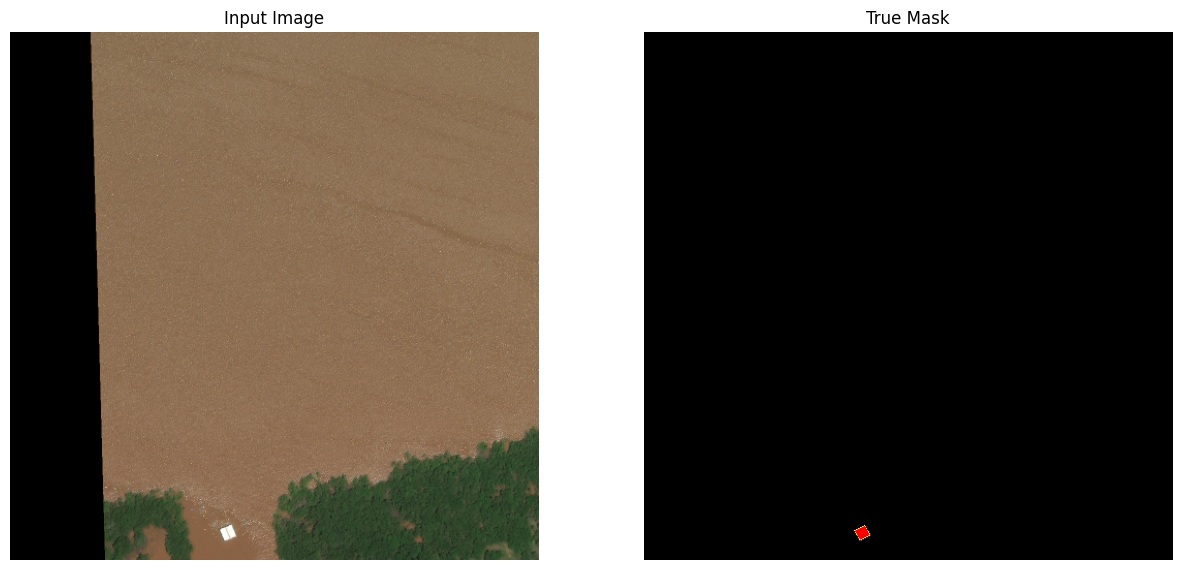

/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_35852/726055826.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


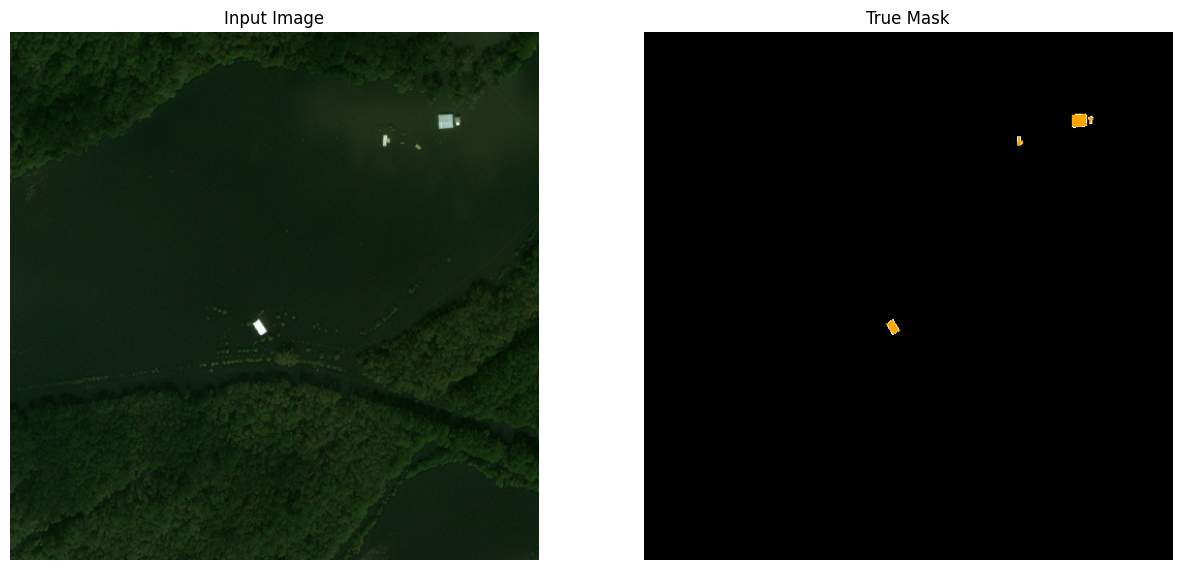

In [29]:
import matplotlib.pyplot as plt

def convert_mask_to_3_channels(mask_1_channel):
    """convert 1 channel mask (numpy array) in 3 channel mask, preserving labels 
    defined in "category_colors" dictionary
    
    Args:
        mask (~numpy.ndarray): A mask array with 1 dimension.
        
    Returns:
        mask (~numpy.ndarray) with 3 channels.
    """
    # Assuming mask_1_channels has shape (height, width, 1)
    height, width = mask_1_channel.shape

    # Create an empty array with shape (height, width, 1) for the single-channel mask
    deep_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Define the colors representing each category (RGB values)
    category_colors = {
        0:(0, 0, 0),        # Class 0 - Black (no building = background) 
        1:(255, 255, 255),  # Class 1 - White (building)  
    }
    # Loop through each pixel and assign the corresponding category to the single-channel mask
    for y in range(height):
        for x in range(width):
            pixel_color = mask_1_channel[y, x]
            category = category_colors.get(pixel_color, (-1,-1,-1))  # -1 for unknown category
            deep_mask[y, x] = category

    return deep_mask

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    # Create the folder if it doesn't exist
    plt.show()

# example on how display function works (using only the first image-mask pair)
for samples in val.take(2):
    
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    #sample_mask = tf.expand_dims(sample_mask, -1)
    sample_mask_deep = convert_mask_to_3_channels(np.array(sample_mask))

    display([sample_image, sample_mask_deep])

In [357]:
# this part was take from: https://keras.io/examples/vision/segformer/

from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            #masks = tf.expand_dims(masks, -1)
            masks_deep=convert_mask_to_3_channels(np.array(masks))
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            pred_mask_create = create_mask(pred_masks)
            pred_mask_create_3ch = convert_mask_to_3_channels(np.array(pred_mask_create))
            display([images[0], masks_deep[0], pred_mask_create_3ch])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [358]:
val.skip(1).take(1)

<_TakeDataset element_spec={'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}>

# Train the Model

1/1 [==============================] - 2s 2s/step


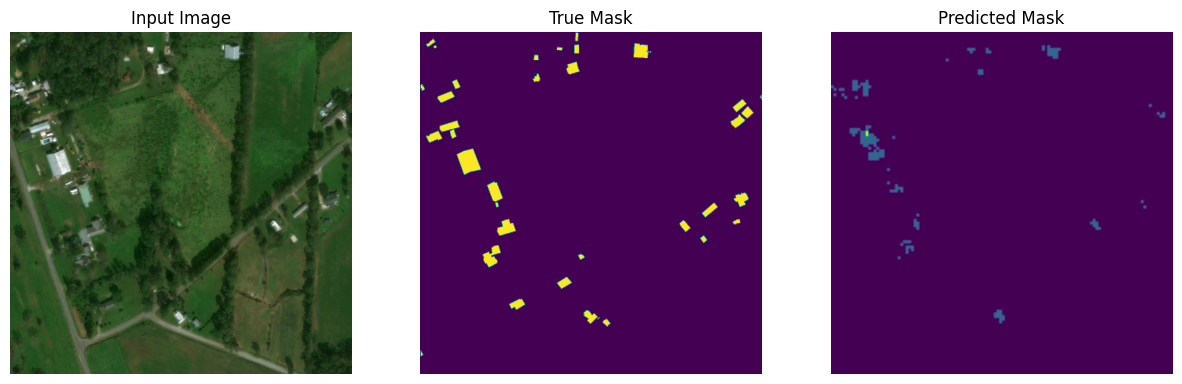


Sample Prediction after epoch 10

82/82 [==============================] - 459s 6s/step - loss: 0.0860 - val_loss: 0.0924


In [359]:
# running model
history = model.fit(
    train,
    validation_data=val,
    callbacks=[DisplayCallback(val)],
    epochs=10,
)


1/1 [==============================] - 2s 2s/step


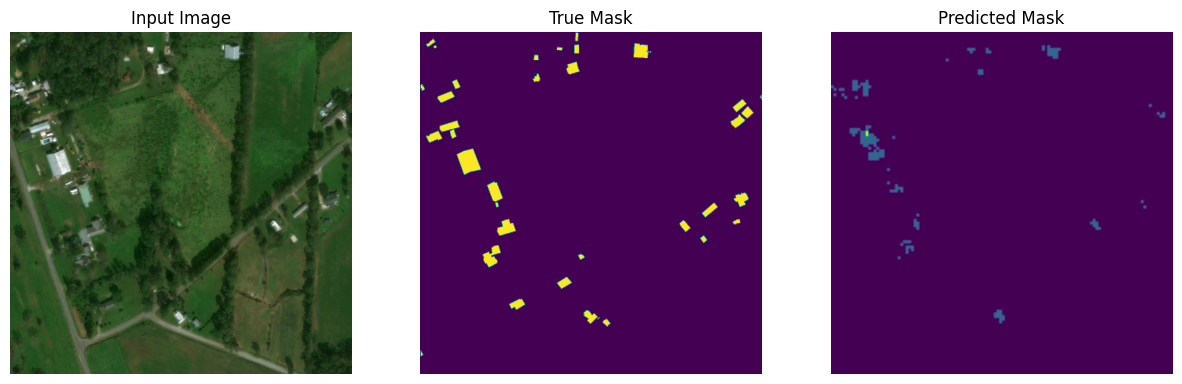

1/1 [==============================] - 2s 2s/step


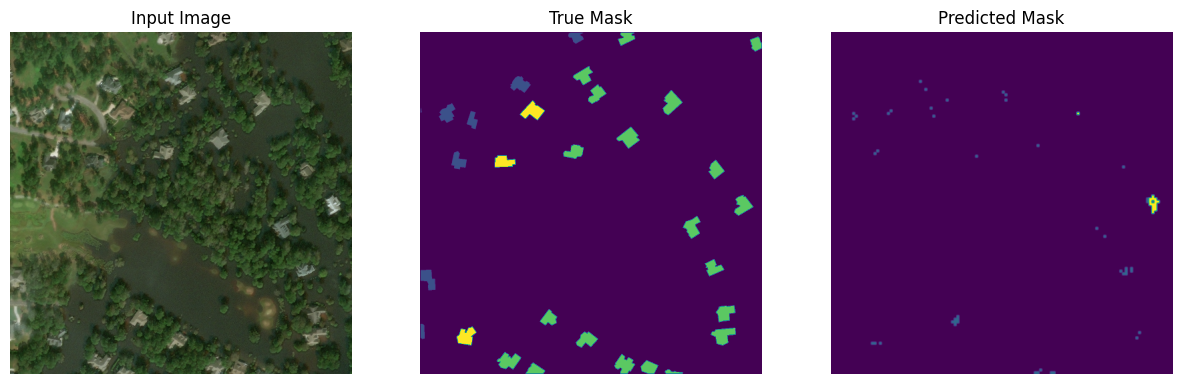

1/1 [==============================] - 2s 2s/step


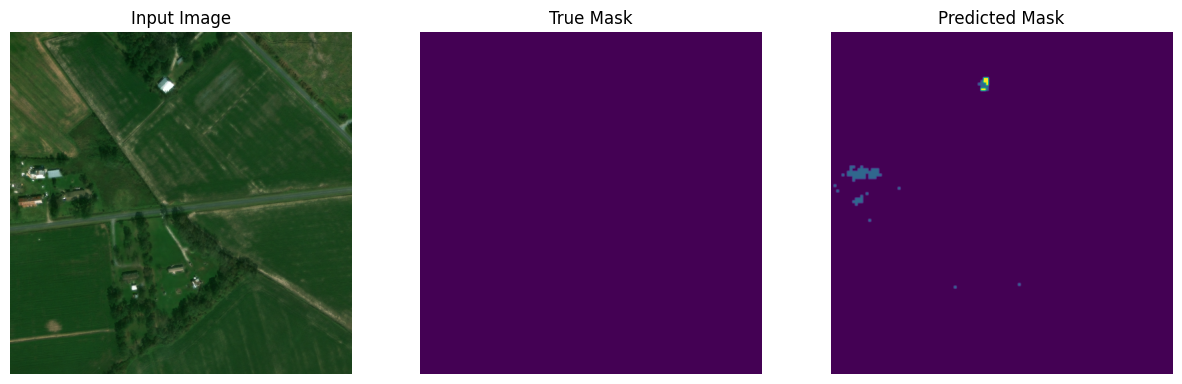

1/1 [==============================] - 2s 2s/step


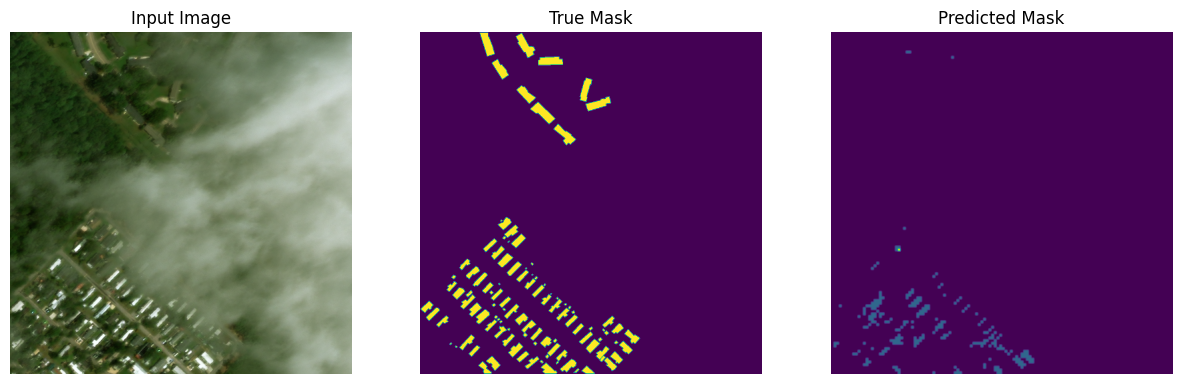

1/1 [==============================] - 2s 2s/step


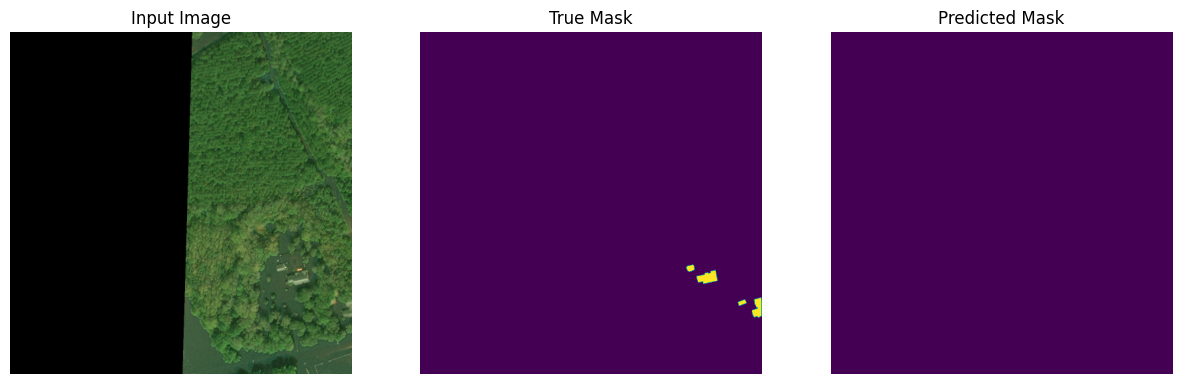

1/1 [==============================] - 2s 2s/step


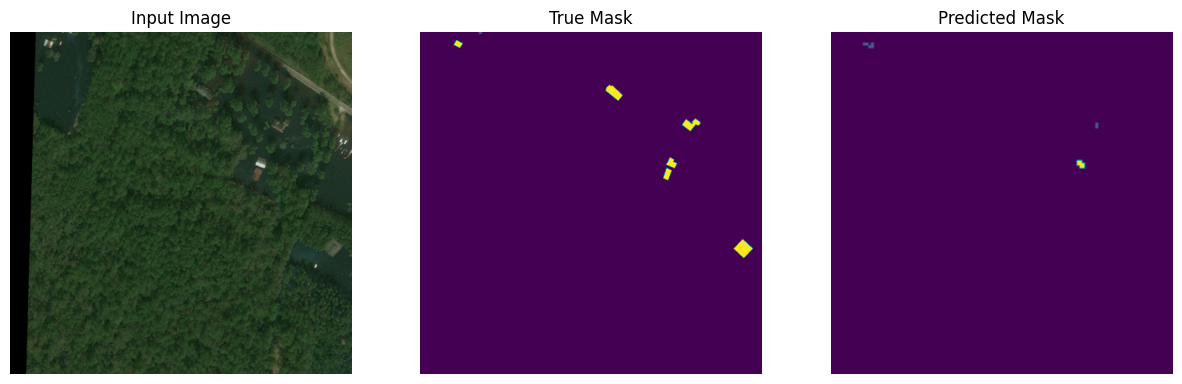

1/1 [==============================] - 2s 2s/step


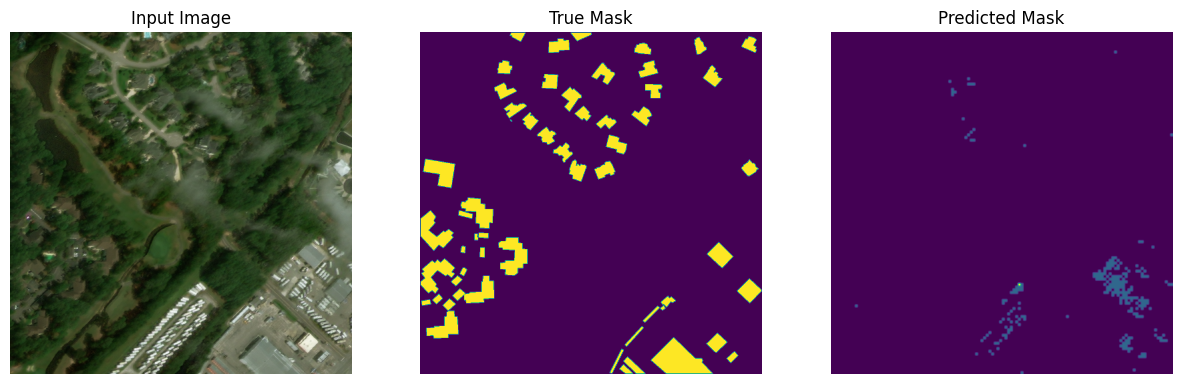

1/1 [==============================] - 2s 2s/step


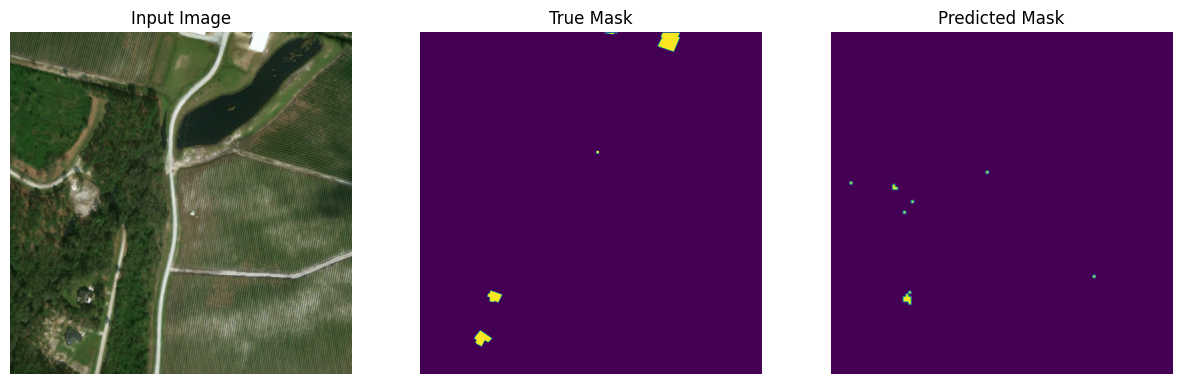

1/1 [==============================] - 2s 2s/step


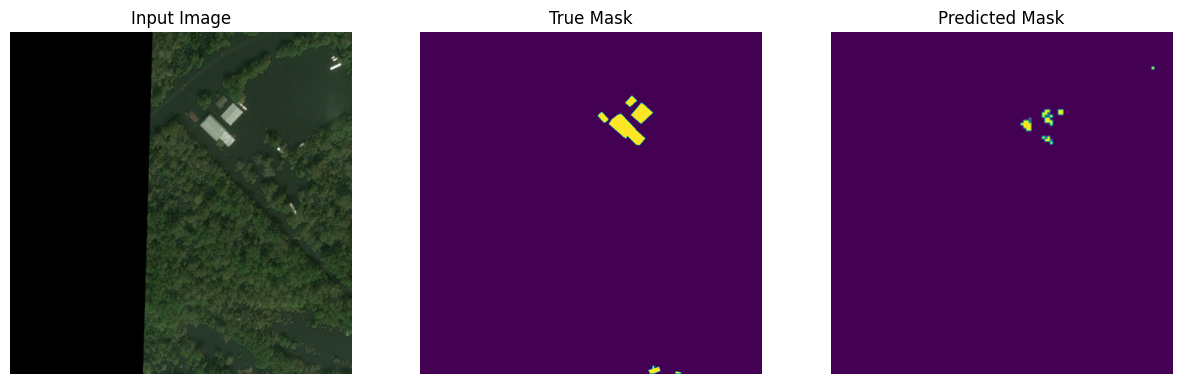

1/1 [==============================] - 2s 2s/step


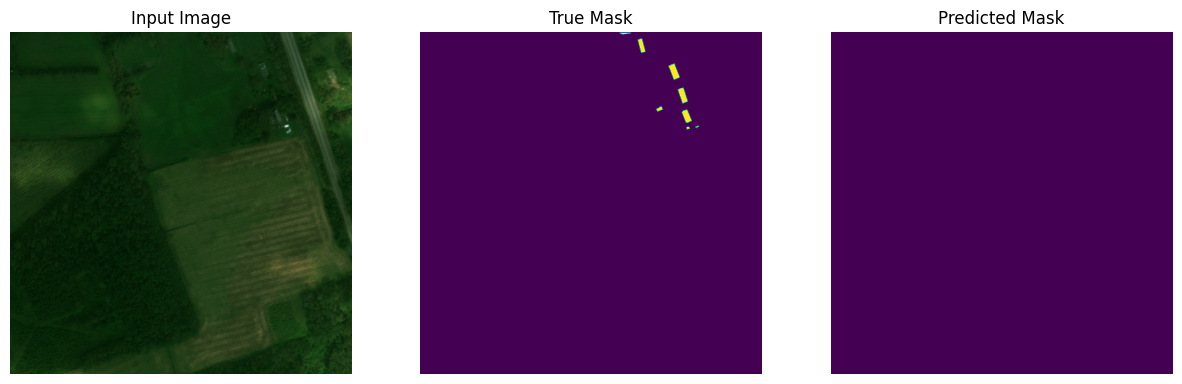

1/1 [==============================] - 1s 512ms/step


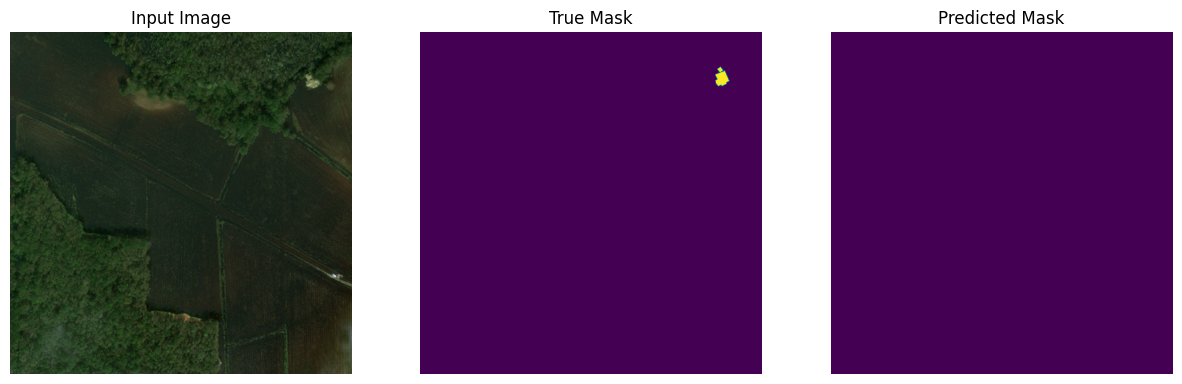

In [364]:
#!pip install ipython
from IPython.display import clear_output
show_predictions(val, 15)

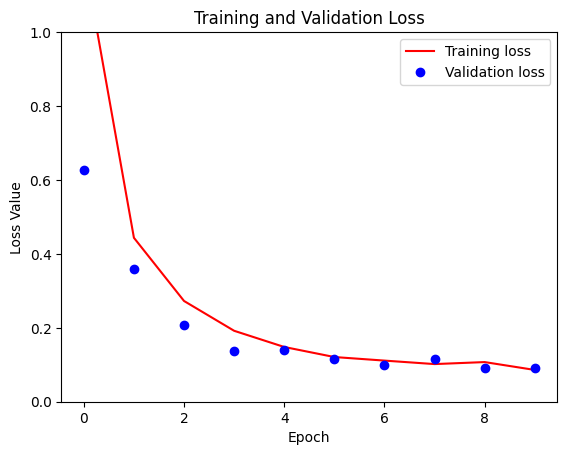

In [366]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()